In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/ann challenge

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/ann challenge


### Import libraries

In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.15.0


In [ ]:
# Import other libraries
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle
import seaborn as sns
plt.rc('font', size=16)
sns.set_theme()

## Auxiliary functions

In [ ]:
def plot_time_series(x: np.ndarray) -> None:
  plt.figure(figsize=(16, 4))
  plt.plot(x)
  plt.title(f"Time series")
  plt.show()

In [ ]:
def plot_history(history, log_scale: bool = False) -> None:
  mae = history['mae']
  val_mae = history['val_mae']
  loss = history['loss']
  val_loss = history['val_loss']
  best_epoch = np.argmin(val_loss)

  plt.figure(figsize=(18, 6))
  plt.subplot(1, 2, 1)
  plt.title('Training and validation MSE')
  plt.xlabel('Epoch')
  plt.ylabel('Mean Squared Error')

  if log_scale:
      plt.semilogy(loss, label='Training MSE', color='#ff7f0e')
      plt.semilogy(val_loss, label='Validation MSE', color='#4D61E2')
  else:
      plt.plot(loss, label='Training MSE', color='#ff7f0e')
      plt.plot(val_loss, label='Validation MSE', color='#4D61E2')

  plt.plot(best_epoch, history['val_loss'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
  plt.grid(True)
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.title('Training and validation MAE')
  plt.xlabel('Epoch')
  plt.ylabel('Mean Absolute Error')

  if log_scale:
     plt.semilogy(mae, label='Training MAE', color='#ff7f0e')
     plt.semilogy(val_mae, label='Validation MAE', color='#4D61E2')
  else:
    plt.plot(mae, label='Training MAE', color='#ff7f0e')
    plt.plot(val_mae, label='Validation MAE', color='#4D61E2')

  plt.plot(best_epoch, history['val_mae'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
  plt.grid(True)
  plt.legend()
  plt.show()

## Load data

In [ ]:
data = np.load('preprocessed_data_stride_50.npz', allow_pickle=True)

In [ ]:
X_train, X_val, y_train, y_val = data["X_train"], data["X_val"], data["y_train"], data["y_val"]

In [ ]:
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)
y_train = np.expand_dims(y_train, axis=-1)
y_val= np.expand_dims(y_val, axis=-1)

In [ ]:
print("Training Data Shape:", X_train.shape)
print("Training Label Shape:", y_train.shape)
print("Validation Data Shape:", X_val.shape)
print("Validation Label Shape:", y_val.shape)

Training Data Shape: (154277, 200, 1)
Training Label Shape: (154277, 9, 1)
Validation Data Shape: (17142, 200, 1)
Validation Label Shape: (17142, 9, 1)


## Build the model

In [ ]:
# Define key model parameters
input_shape = X_train.shape[1:]         # Input shape for the model
output_shape = y_train.shape[1:]        # Output shape for the model
batch_size = 256                        # Batch size for training
epochs = 200                            # Number of training epochs

# Print the defined parameters
print("Epochs:", epochs)
print("Batch Size:", batch_size)
print("Input Shape:", input_shape)
print("Output Shape:", output_shape)

Epochs: 200
Batch Size: 256
Input Shape: (200, 1)
Output Shape: (9, 1)


In [ ]:
initializer = tf.keras.initializers.HeNormal()

def build_model(input_shape, output_shape):
  # Ensure the input time steps are at least as many as the output time steps
  assert input_shape[0] >= output_shape[0]

  # Define the input layer with the specified shape
  input_layer = tfkl.Input(shape=input_shape, name='input_layer')

  # Add a Bidirectional GRU layer with 128 units
  x = tfkl.Bidirectional(tfkl.GRU(128, return_sequences=True, name='gru1'), name='bidirectional_gru1')(input_layer)

  # Add a Bidirectional GRU layer with 128 units
  x = tfkl.Bidirectional(tfkl.GRU(128, return_sequences=True, name='gru2'), name='bidirectional_gru2')(x)

  # Add a Dropout layer
  x = tfkl.Dropout(0.3, name='dropout')(x)

  # Add a 1D Convolution layer with 128 filters and a kernel size of 3
  x = tfkl.Conv1D(128, 3, padding='same', activation='relu', name='conv')(x)

  # Add a final Convolution layer to match the desired output shape
  output_layer = tfkl.Conv1D(output_shape[1], 3, padding='same', name='output_layer')(x)

  # Apply pooling to get to the desired length
  output_layer = tfkl.AveragePooling1D(22, name='pooling')(output_layer)

  # Construct the model by connecting input and output layers
  model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_GRU_model')

  # Compile the model with Mean Squared Error loss and Adam optimizer
  model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-3), metrics=['mae'])

  return model

In [ ]:
model = build_model(input_shape, output_shape)
model_name = model.name
model.summary()

Model: "CONV_GRU_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 200, 1)]          0         
                                                                 
 bidirectional_gru1 (Bidire  (None, 200, 256)          100608    
 ctional)                                                        
                                                                 
 bidirectional_gru2 (Bidire  (None, 200, 256)          296448    
 ctional)                                                        
                                                                 
 dropout (Dropout)           (None, 200, 256)          0         
                                                                 
 conv (Conv1D)               (None, 200, 128)          98432     
                                                                 
 output_layer (Conv1D)       (None, 200, 1)         

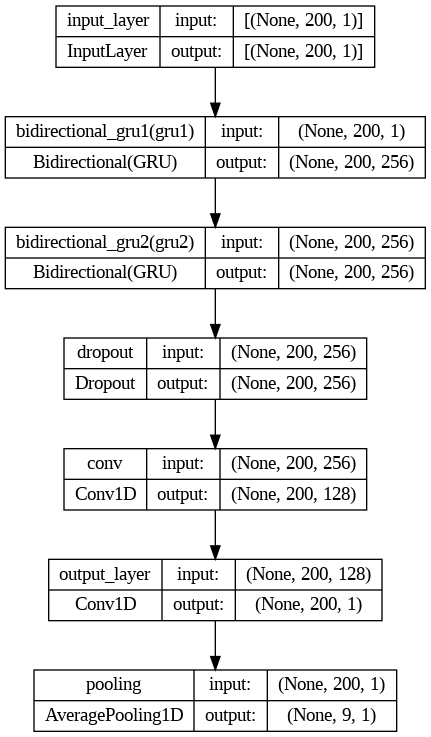

In [ ]:
tfk.utils.plot_model(model, show_shapes=True)

In [ ]:
lr_patience = 7
es_patience = 20
callbacks = [
    tfk.callbacks.TerminateOnNaN(),
    tfk.callbacks.ReduceLROnPlateau('val_loss', patience=lr_patience, factor=0.3, min_lr=1e-5, verbose=1),
    tfk.callbacks.EarlyStopping('val_loss', patience=es_patience, restore_best_weights=True, verbose=1)
]

## Train model

In [ ]:
# Train the model and save its history
model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
);

Epoch 1/200
603/603 [==============================] - 71s 98ms/step - loss: 0.0346 - mae: 0.1351 - val_loss: 0.0135 - val_mae: 0.0785 - lr: 0.0010
Epoch 2/200
603/603 [==============================] - 57s 95ms/step - loss: 0.0135 - mae: 0.0799 - val_loss: 0.0129 - val_mae: 0.0785 - lr: 0.0010
Epoch 3/200
603/603 [==============================] - 58s 97ms/step - loss: 0.0123 - mae: 0.0749 - val_loss: 0.0141 - val_mae: 0.0863 - lr: 0.0010
Epoch 4/200
603/603 [==============================] - 59s 98ms/step - loss: 0.0114 - mae: 0.0718 - val_loss: 0.0107 - val_mae: 0.0689 - lr: 0.0010
Epoch 5/200
603/603 [==============================] - 59s 98ms/step - loss: 0.0109 - mae: 0.0699 - val_loss: 0.0104 - val_mae: 0.0669 - lr: 0.0010
Epoch 6/200
603/603 [==============================] - 59s 97ms/step - loss: 0.0105 - mae: 0.0681 - val_loss: 0.0110 - val_mae: 0.0714 - lr: 0.0010
Epoch 7/200
603/603 [==============================] - 59s 98ms/step - loss: 0.0102 - mae: 0.0669 - val_loss: 0.

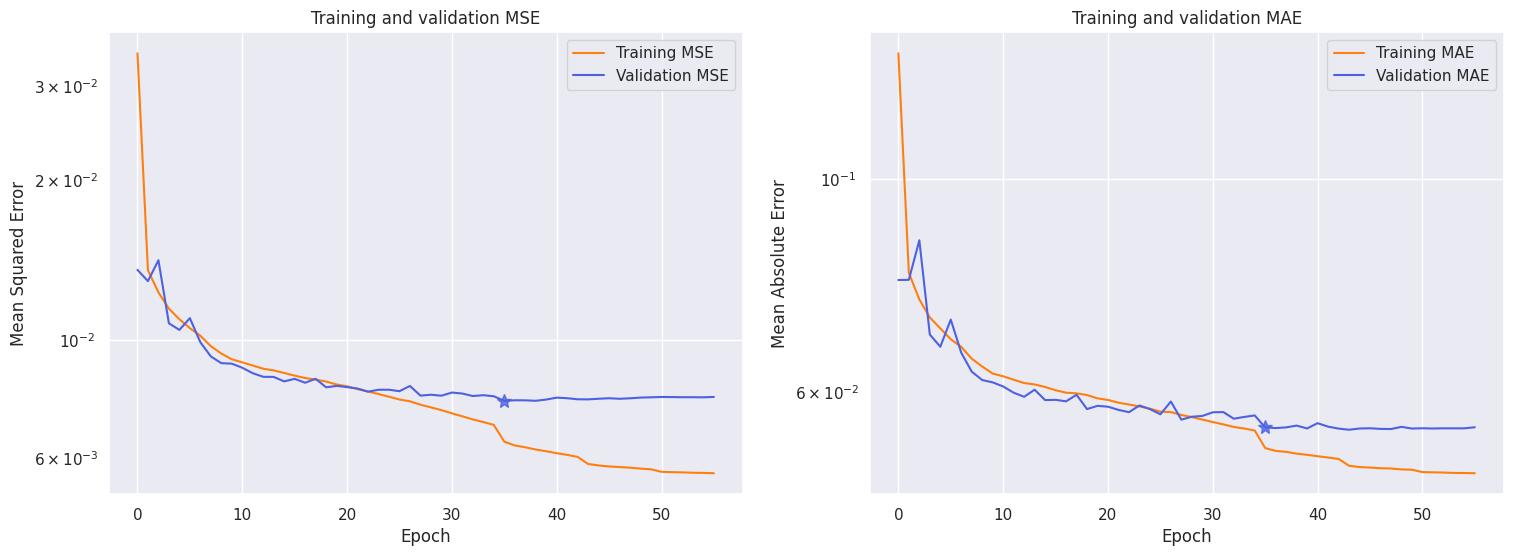

In [ ]:
plot_history(model.history.history, log_scale=True)

In [ ]:
# Save the trained model
model.save('models/' + model.name)
del model

In [ ]:
model = tfk.models.load_model('models/' + model_name)

In [ ]:
mse, mae = model.evaluate(X_val, y_val)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")

536/536 [==============================] - 9s 14ms/step - loss: 0.0077 - mae: 0.0552
Mean Squared Error: 0.00767550291493535
Mean Absolute Error: 0.05515887960791588
